# **`Import`**

In [51]:
!pip install torchmetrics

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy, HingeLoss

# **`Device`**

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **`Laod Dataset`**

In [101]:
data_frame_train = pd.read_csv('/content/train.csv')
date_frame_test = pd.read_csv('/content/test.csv')

# **`Train`**

In [102]:
x_train = data_frame_train.drop('price_range', axis=1).values
y_train = data_frame_train['price_range'].values

# **`Split`**

In [103]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.7, random_state=42)

# **`Preprocess`**

In [104]:
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)


# for validation

x_valid = torch.FloatTensor(x_valid)
y_valid = torch.LongTensor(y_valid)


# **`Standardization`**

In [105]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

In [106]:
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

# **`Dataloader`**

In [107]:
train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)

In [108]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64)

# **`Utils`**

In [109]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **`Model`**

In [110]:
num_feats = 20
num_class = 4
hiden_layer_one = 64
hiden_layer_two = 32

model = nn.Sequential(nn.Linear(num_feats, hiden_layer_one),
                      nn.ReLU(),
                      nn.Linear(hiden_layer_one, hiden_layer_two),
                      nn.ReLU(),
                      nn.Linear(hiden_layer_two, num_class)
                      )

model = model.to(device)


# **`Loss and Optimizer`**


In [111]:
# loss_fn = HingeLoss(task='multiclass', num_classes=4)
# loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [112]:
def loss_fn(outputs, targets, alpha=1., gamma=2.):
    weights = torch.ones(outputs.shape[1]) * alpha
    prob = F.softmax(outputs, dim=1)
    outputs = (1 - prob)**gamma * torch.log(prob)
    return F.nll_loss(outputs, targets, weights)


# **`Train loop`**

In [113]:
from os import listxattr
num_epochs = 400

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []


for epoch in range(num_epochs):
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=4).to(device)
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets)




    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass', num_classes=4).to(device)

        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            # valid_loss.append(loss)
            loss_valid.update(loss.item())

            acc_valid(outputs, targets)

    loss_train_hist.append(loss_train.avg)
    loss_valid_hist.append(loss_valid.avg)

    acc_train_hist.append(acc_train.compute())
    acc_valid_hist.append(acc_valid.compute())




    if epoch % 10 == 0:

        print(f'Epoch {epoch}')

        print(f'Train: Loss = {loss_train.avg:.4}, Acc = {acc_train.compute():.4}')

        print(f'Valid: Loss = {loss_valid.avg:.4}, Acc = {acc_valid.compute():.4}', "\n")



Epoch 0
Train: Loss = 0.7839, Acc = 0.2493
Valid: Loss = 0.7754, Acc = 0.2783 

Epoch 10
Train: Loss = 0.7038, Acc = 0.4907
Valid: Loss = 0.6991, Acc = 0.5133 

Epoch 20
Train: Loss = 0.5586, Acc = 0.615
Valid: Loss = 0.5545, Acc = 0.6183 

Epoch 30
Train: Loss = 0.3856, Acc = 0.7621
Valid: Loss = 0.3857, Acc = 0.7367 

Epoch 40
Train: Loss = 0.2638, Acc = 0.85
Valid: Loss = 0.2685, Acc = 0.83 

Epoch 50
Train: Loss = 0.1918, Acc = 0.8921
Valid: Loss = 0.1988, Acc = 0.8517 

Epoch 60
Train: Loss = 0.1479, Acc = 0.9064
Valid: Loss = 0.1559, Acc = 0.8817 

Epoch 70
Train: Loss = 0.1191, Acc = 0.9236
Valid: Loss = 0.1277, Acc = 0.8983 

Epoch 80
Train: Loss = 0.09922, Acc = 0.93
Valid: Loss = 0.1084, Acc = 0.9067 

Epoch 90
Train: Loss = 0.08485, Acc = 0.94
Valid: Loss = 0.09468, Acc = 0.9067 

Epoch 100
Train: Loss = 0.07404, Acc = 0.9421
Valid: Loss = 0.0846, Acc = 0.9067 

Epoch 110
Train: Loss = 0.06573, Acc = 0.9486
Valid: Loss = 0.07702, Acc = 0.9067 

Epoch 120
Train: Loss = 0.0592

# **`Plot`**

# **`Loss`**

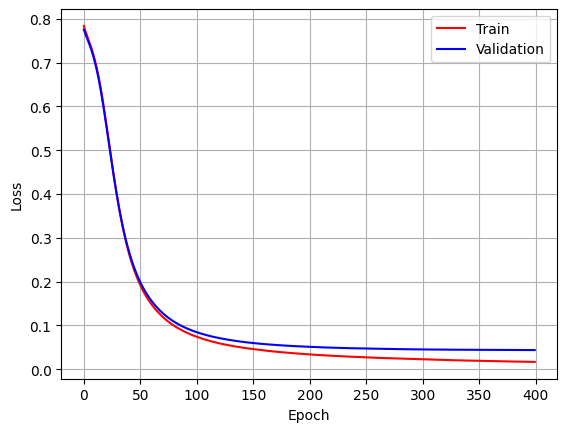

In [116]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# **`Accuracy`**

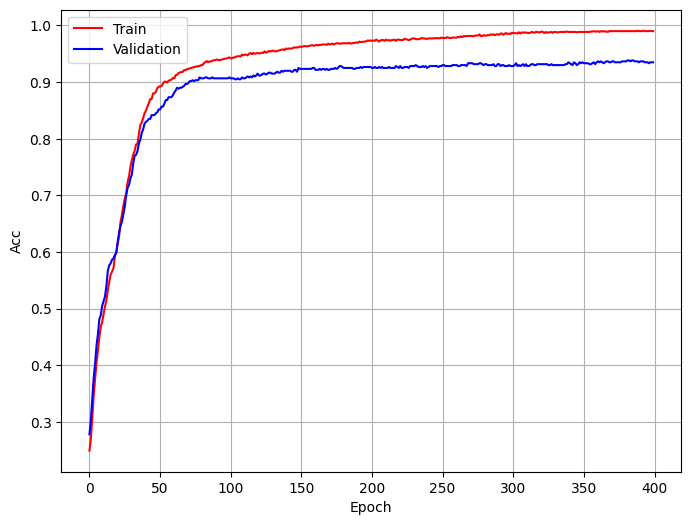

In [117]:
plt.figure(figsize=(8, 6))

plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()